HSE, Applied Time Series Forecasitng , Fall 2023

<font color="green"> Lesson #2: Simple Exponential Smoothing Model </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** simple exponential smoothing, adaptive exponential smoothing, retail time series

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/EQgXEVQe9PPXUBzm6"> here </a>

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

import math
import pandas.tseries.offsets as ofs


# Typical TS for SES Model

## TS in Retail

In [2]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', parse_dates=['Dates'], dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

Item:  165  Item:  969  Item: 2653  Item: 2654  Item: 2692  \
Timestamp                                                                
2005-01-11         NaN         2.0         4.0         NaN         NaN   
2005-01-12         NaN         5.0         8.0         NaN         NaN   
2005-01-13         NaN         2.0        20.0         NaN         NaN   
2005-01-14         NaN        42.0        14.0         NaN         NaN   
2005-01-15         NaN         NaN        23.0         NaN         NaN   

            Item: 2695  Item: 2697  Item: 2765  Item: 2767  Item: 2806  \
Timestamp                                                                
2005-01-11         NaN         NaN         NaN         NaN         NaN   
2005-01-12         NaN         NaN         NaN         NaN         NaN   
2005-01-13         NaN         NaN         NaN         NaN         NaN   
2005-01-14         NaN         NaN         NaN         NaN         NaN   
2005-01-15         NaN         NaN         NaN         NaN         NaN   

            Item: 2808  
Timestamp               
2005-01-11         NaN  
2005-01-12         NaN  
2005-01-13         NaN  
2005-01-14         NaN  
2005-01-15         NaN

In [3]:
# Interval of ts
ts.loc['2007-01-01':'2007-01-05']

Item:  165  Item:  969  Item: 2653  Item: 2654  Item: 2692  \
Timestamp                                                                
2007-01-01         NaN         NaN         NaN         NaN         NaN   
2007-01-02         NaN        21.0        11.0         NaN         7.0   
2007-01-03         NaN        10.0        15.0         NaN        21.0   
2007-01-04         NaN         NaN         4.0         NaN         7.0   
2007-01-05         NaN         3.0        36.0         NaN        14.0   

            Item: 2695  Item: 2697  Item: 2765  Item: 2767  Item: 2806  \
Timestamp                                                                
2007-01-01         NaN         NaN         NaN         NaN         NaN   
2007-01-02         2.0         NaN         7.0         1.0         3.0   
2007-01-03         7.0         NaN         2.0         3.0         0.0   
2007-01-04         NaN         NaN        12.0         1.0         NaN   
2007-01-05         NaN         NaN         6.0        10.0         4.0   

            Item: 2808  
Timestamp               
2007-01-01         NaN  
2007-01-02         5.0  
2007-01-03         2.0  
2007-01-04         1.0  
2007-01-05         1.0

**Questions**
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



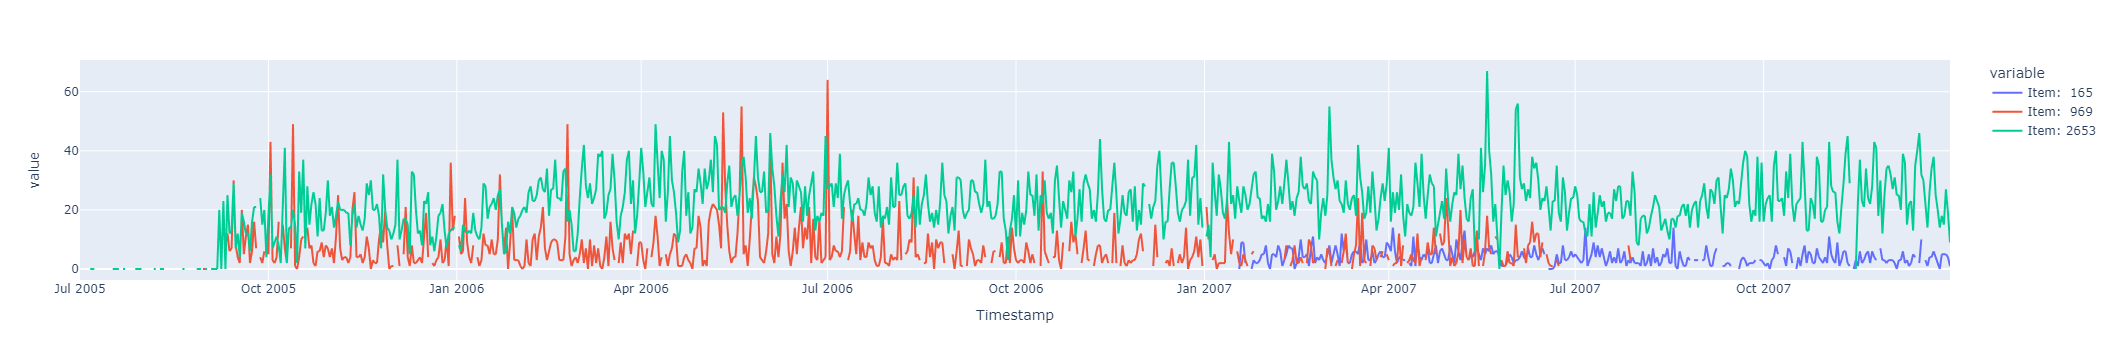

In [4]:
# draw some ts in this set
ts.loc['2005-07-01':'2007-12-31', ts.columns[range(3)]].plot().update_layout(height=350, width=1300).show()

**Questions**

 - What are key aspects of these retail ts?


C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



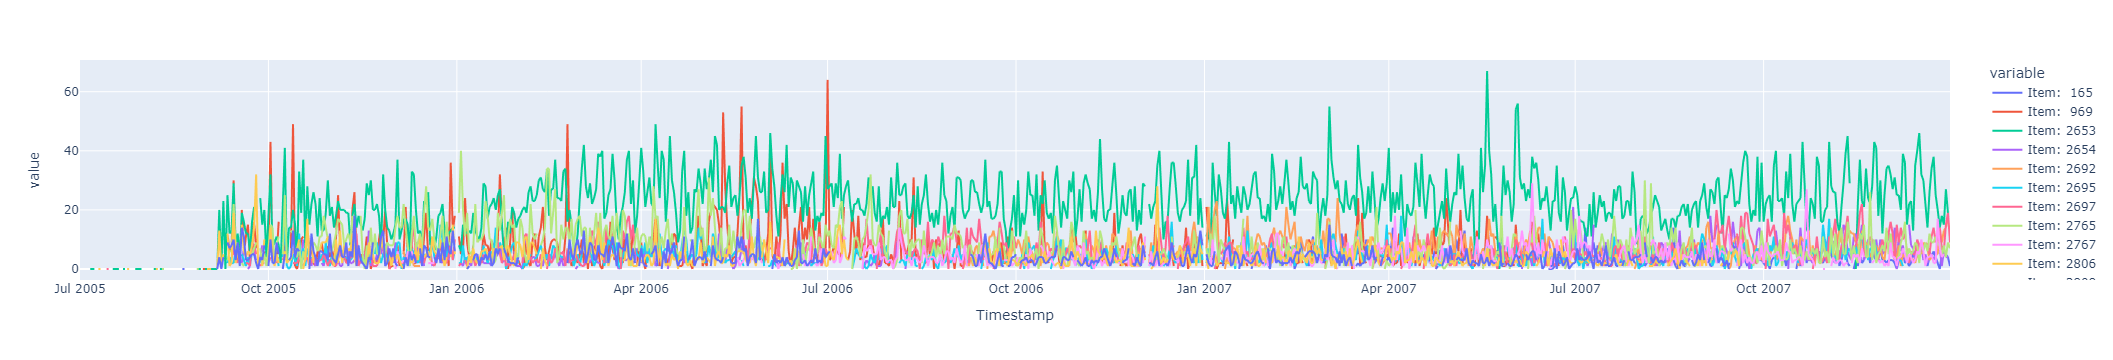

In [5]:
# let's look at all 10 ts in this ts
ts.loc['2005-07-01':'2007-12-31'].plot().update_layout(height=350, width=1300)

**Questions**

 - Any idea how to predict such ts?
 - Can you describe statistical model for such ts?

###### Answer



$$y_{t} = l_t + \color{red}{\varepsilon_t},$$

where $l_t$ $-$ changing slowly level of time series,

$\varepsilon_t~-$ error component (unobserved noise)

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$

where $\hat l_t~-$ an estimation of level


## Moving Average

**Rolling window n**
       $$\hat y_{t+d} = \frac{1}{n}\left(y_{t-n+1}+\dots+ {y}_t\right)$$
   
**All points in  $[t-n+1, t]$ has the same weight**
                                   $$w = \frac{1}{n}$$
**Other points has weight**
                                    $$w = 0$$

In [6]:
# Rolling moving (n = 2 и n=28)
item_name = u'Item:  165'
start_period = '2008-01-01'
end_period = '2008-01-31'

# Note: replace NaN before average calculation
ts.loc[start_period:end_period][[item_name]].merge(
      ts[[item_name]].fillna(method='pad').rolling(2).mean().loc[start_period:end_period].rename(columns = {item_name:'MA window=2'}),  # moving average with window = 2
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').rolling(28).mean().loc[start_period:end_period].rename(columns = {item_name:'MA window=28'}),  # moving average with window = 28
      how='inner', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1047537645.py:8: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1047537645.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Expanding window**
       $$\hat y_{t+d} = \frac{1}{t}\left(y_{1}+\dots+ {y}_t\right)$$
   
**All time points in $[1, t]$ has the same weight**
                                   $$w = \frac{1}{t}$$   

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\2456631993.py:3: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



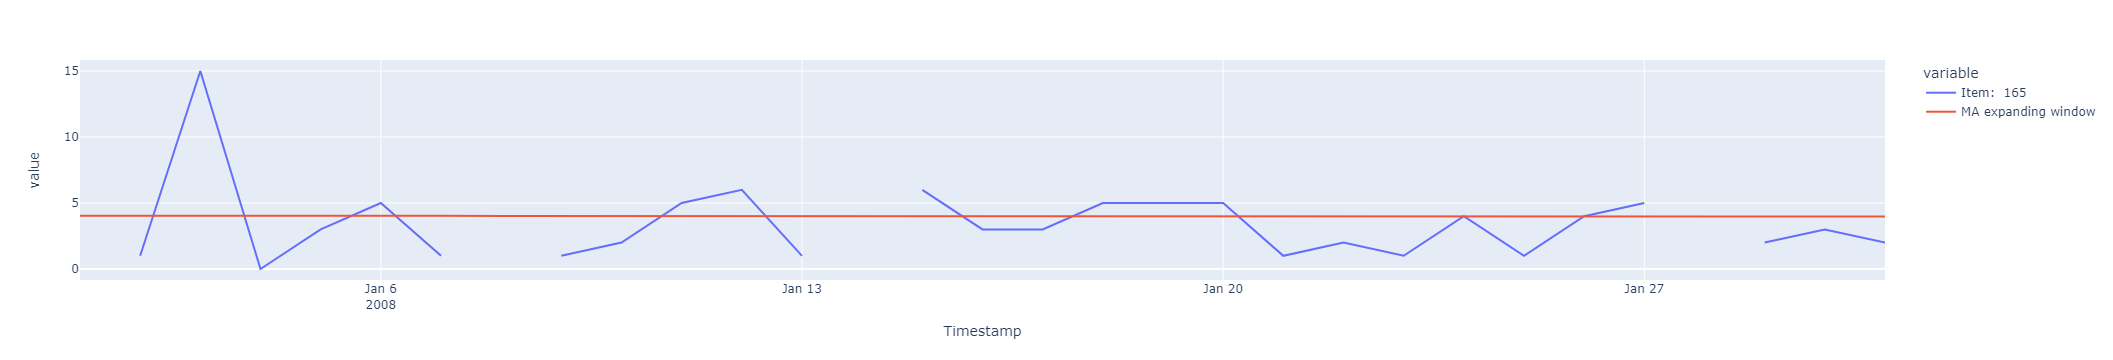

In [7]:
# Expanding window
ts.loc[start_period:end_period][[item_name]].merge(
      ts[[item_name]].fillna(method='pad').expanding().mean().loc[start_period:end_period].rename(columns = {item_name:'MA expanding window'}),  # moving average with window = 2
      how='inner', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300)

**Questions**

 - What are analytical disadvantages of using movinag average algorithm?

  <!-- - <font color="green">Answers:
    - awkward implementation (we have to remember last window ts points)
    - it is not smooth (weights are not smooth within time) </font> -->

## Exponentially Wighted Moving Average

**Exponentialy diminishing weights**
    $$\hat y_{t+d}= \alpha y_t + \alpha \left(1-\alpha\right)y_{t-1} + \alpha \left(1-\alpha\right)^2y_{t-2}+\dots = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau$$
   
**Weight for time point in moment $\tau$**
    $$w_\tau = \alpha\cdot (1-\alpha)^{t-\tau}$$  


In [8]:
# comprehanding timestamp weights
t = 10
alpha_set = [0.001, 0.1, 0.15, 0.2, 0.5, 0.9]
pd.DataFrame(data = [[a*(1-a)**(t-tau) for a in alpha_set] for tau in range(1,t+1,1)], columns = [r'\alpha=' + str(x) for x in alpha_set], index = range(1,t+1,1)).sort_index(ascending = False)

\alpha=0.001  \alpha=0.1  \alpha=0.15  \alpha=0.2  \alpha=0.5  \
10      0.001000    0.100000     0.150000    0.200000    0.500000   
9       0.000999    0.090000     0.127500    0.160000    0.250000   
8       0.000998    0.081000     0.108375    0.128000    0.125000   
7       0.000997    0.072900     0.092119    0.102400    0.062500   
6       0.000996    0.065610     0.078301    0.081920    0.031250   
5       0.000995    0.059049     0.066556    0.065536    0.015625   
4       0.000994    0.053144     0.056572    0.052429    0.007812   
3       0.000993    0.047830     0.048087    0.041943    0.003906   
2       0.000992    0.043047     0.040874    0.033554    0.001953   
1       0.000991    0.038742     0.034743    0.026844    0.000977   

      \alpha=0.9  
10  9.000000e-01  
9   9.000000e-02  
8   9.000000e-03  
7   9.000000e-04  
6   9.000000e-05  
5   9.000000e-06  
4   9.000000e-07  
3   9.000000e-08  
2   9.000000e-09  
1   9.000000e-10

HINT: Approximation of $window$ in MA and $\alpha$ in Exponential Smoothing (only for $alpha<0.1$)

$$window \approx \frac{1}{2\alpha}$$

In [11]:
# Averaging with exponential weights
item_name = u'Item:  165'
start_period = '2008-01-01'
end_period = '2008-01-31'

# Note: replace NaN before average calculation
ts.loc[start_period:end_period][[item_name]].merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=0.9).mean().loc[start_period:end_period].rename(columns = {item_name:'($EWMA(\\alpha=.9)$'}),  # ewma alpha =0.9
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=0.5).mean().loc[start_period:end_period].rename(columns = {item_name:'$EWMA(\\alpha=.5)$'}),  # ewma alpha =0.5
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=0.1).mean().loc[start_period:end_period].rename(columns = {item_name:'$EWMA(\\alpha=.1)$'}),  # ewma alpha =0.1
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=0.01).mean().loc[start_period:end_period].rename(columns = {item_name:'$EWMA(\\alpha=.01)$'}),  # ewma alpha =0.01
      how='inner', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1616458227.py:8: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1616458227.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1616458227.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\1616458227.py:17: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a futur

**Parameter $\alpha$ drives the depth of the historical period to be considered!**

$\alpha \uparrow 1 \; \Rightarrow$ EWMA is closer to Moving Average with window = 1,

$\alpha \downarrow 0 \; \Rightarrow$ EWMA is closer to Moving Average with expanding window.

In [12]:
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [13]:
# Compare EWMA (alpha = 0.001) and Expanding
alpha_small = 0.0001
ts.loc[start_period:end_period][[item_name]].merge(
      ts[[item_name]].fillna(method='pad').expanding().mean().loc[start_period:end_period].rename(columns = {item_name:'MA expanding window'}),  # MA with expanding window
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=alpha_small).mean().loc[start_period:end_period].rename(columns = {item_name:'$EWMA(\\alpha={0})$'.format(alpha_small)}),  # ewma with small alpha
      how='inner', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_17496\3720028121.py:4: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_17496\3720028121.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [14]:
# Compare EWMA (alpha = 0.9) and MA (window = 1)
# ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')

alpha_big = 0.9
ts.loc[start_period:end_period][[item_name]].merge(
      ts[[item_name]].fillna(method='pad').rolling(1).mean().loc[start_period:end_period].rename(columns = {item_name:'MA window=1'}),  # MA with expanding window
      how='inner', left_index = True, right_index = True
      ).merge(
      ts[[item_name]].fillna(method='pad').ewm(alpha=alpha_big).mean().loc[start_period:end_period].rename(columns = {item_name:'$EWMA(\\alpha={0})$'.format(alpha_big)}),  # ewma with small alpha
      how='inner', left_index = True, right_index = True
      ).plot().update_layout(height=350, width=1300)


C:\Users\lakeo\AppData\Local\Temp\ipykernel_17496\4166513844.py:6: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\AppData\Local\Temp\ipykernel_17496\4166513844.py:9: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Simple Exponential Smoothing

## A bit of Theory

**Sum notation**:
$$\hat{y}_{t+1} = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau~~~~~(1)$$

**Recurrent formula notation:**
$$\hat{y}_{t+1} = ~\underbrace{\color{green}\alpha\cdot y_t+ (1-\color{green}\alpha)\cdot \hat{y}_{t} }_{\text{canonical formula}}~= ~\underbrace{\hat y_t + \color{green}\alpha \cdot \color{red}{e_t}}_{\text{error correction formula}}$$
where ${\color{red}{e_t} = y_t - \hat y_t }$


**Question:**
 * What is the problem with this formla (1)?
 * Hint: calculate sum of weights of time series points.


  <!-- - <font color = 'green'>Answer
    - sum or weights is less than 1</font> -->

## SES Realization

In [12]:
# Example of realization

# Simple Exponential Smoothing
# x <array Tx1>- time series,
# h <scalar> - forecasting delay
# Params <dict> - dictionary with
#    alpha <scalar in [0,1]> - smoothing parameter

def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y)
            #else do not nothing
        FORECAST[cntr+h] = y # academic forecast, for ML training
        # FORECAST_PRODUCTION = FORECAST
        # FORECAST_PRODUCTION[T:] = FORECAST_PRODUCTION[T+h] # production forecast
    return FORECAST #, FORECAST[T+h]

In [25]:
# Forecast delay = 1
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [26]:
frc_ts

Item:  165 Item:  969 Item: 2653 Item: 2654 Item: 2692 Item: 2695  \
2005-01-11        NaN        NaN        NaN        NaN        NaN        NaN   
2005-01-12        NaN        NaN        NaN        NaN        NaN        NaN   
2005-01-13        NaN        NaN        NaN        NaN        NaN        NaN   
2005-01-14        NaN        NaN        NaN        NaN        NaN        NaN   
2005-01-15        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2009-02-27        NaN        NaN        NaN        NaN        NaN        NaN   
2009-02-28        NaN        NaN        NaN        NaN        NaN        NaN   
2009-03-01        NaN        NaN        NaN        NaN        NaN        NaN   
2009-03-02        NaN        NaN        NaN        NaN        NaN        NaN   
2009-03-03        NaN        NaN        NaN        NaN        NaN        NaN   

           Item: 2697 Item: 2765 Item: 2767 Item: 2806 Item: 2808  
2005-01-11        NaN        NaN        NaN        NaN        NaN  
2005-01-12        NaN        NaN        NaN        NaN        NaN  
2005-01-13        NaN        NaN        NaN        NaN        NaN  
2005-01-14        NaN        NaN        NaN        NaN        NaN  
2005-01-15        NaN        NaN        NaN        NaN        NaN  
...               ...        ...        ...        ...        ...  
2009-02-27        NaN        NaN        NaN        NaN        NaN  
2009-02-28        NaN        NaN        NaN        NaN        NaN  
2009-03-01        NaN        NaN        NaN        NaN        NaN  
2009-03-02        NaN        NaN        NaN        NaN        NaN  
2009-03-03        NaN        NaN        NaN        NaN        NaN  

[1513 rows x 11 columns]

In [27]:
# ES params
Params ={'alpha':0.1}

# generate forecasts for each Item
for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, Params)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getit

In [28]:
# show SES forecast alpha = 0.1
def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[[ts.columns[ts_num]]].merge(frc_ts[[frc_ts.columns[ts_num]]], how = 'outer', left_index = True, right_index = True)\
      .plot().update_layout(height=350, width=1300,
                  xaxis_title="time ticks",
                  yaxis_title="ts and forecast values").show()
    return

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



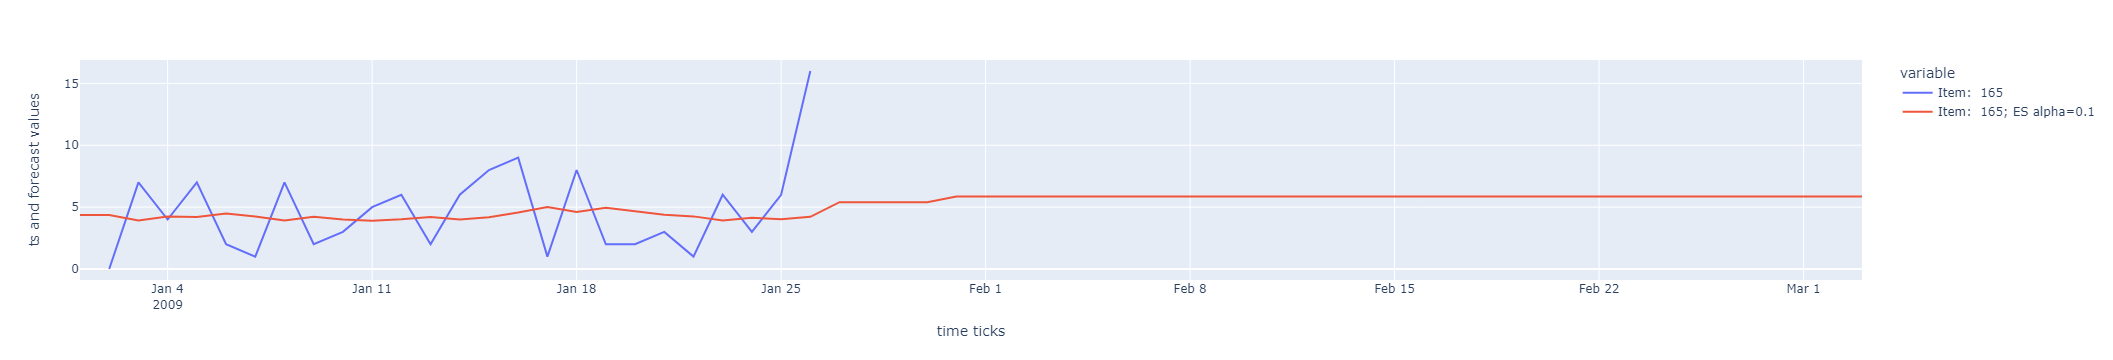

In [29]:
plot_ts_forecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

**Question:**
 * Why the forecasts values for 27th, 28th, 29th and 30th of January are the same?
 * When does the last change of the forecast value occur?  

In [30]:
# Generate forecast for h = 30
h = 30
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':0.1})

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getit

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



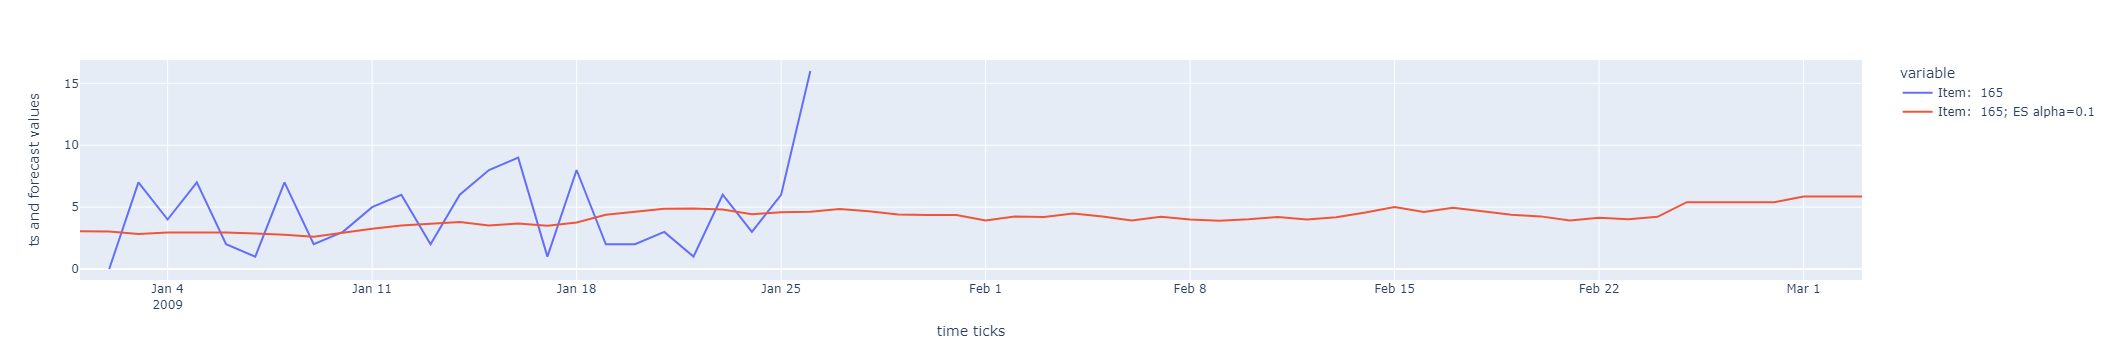

In [31]:
# show forecast h = 30, alpha = 0.1
plot_ts_forecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

## Search for the optimal $\alpha$

In [32]:
def build_forecast(h, ts, alg_name, alg_title, params, step='D'):
  'grid'

  FRC_TS = dict()

  for p in params:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)

      for cntr in ts.columns:
          frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)

#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
      FRC_TS['%s %s' % (alg_title, p)] = frc_ts

  return FRC_TS

In [33]:
#Fit parameters
ALPHA = [0.9, 0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01, 0.001, 0.00001]
ESparams = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, alg_name =  'SimpleExponentialSmoothing', alg_title='ES' ,params = ESparams)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getit

Loss of the SES forecast for all history

In [34]:
# intoduce loss function
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
  qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
  return qlt.mean() , (x-y).abs()

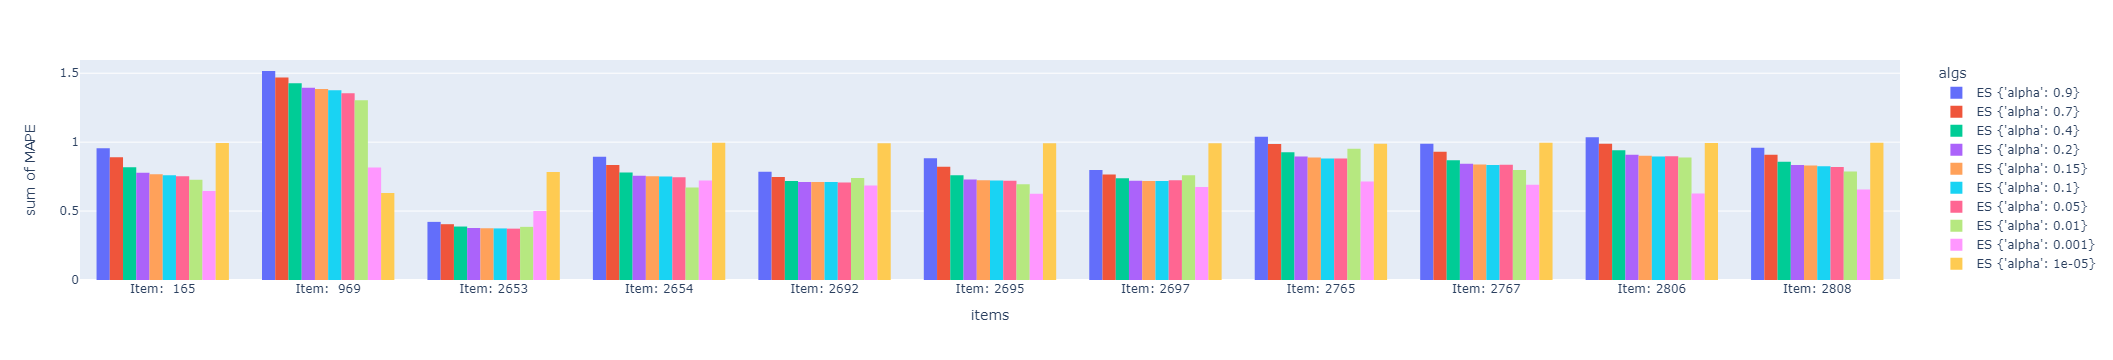

In [35]:
# compare ES parameters
quality_wholehist = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within all 1500 steps
for param_cntr in sorted(quality_wholehist.columns):
    frc_ts = FRC_TS[param_cntr]
    quality_wholehist[param_cntr],_ = qualityMAPE(ts, frc_ts.loc[ts.index])


px.histogram(quality_wholehist.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'}), x="items", y="MAPE",
             color='algs', barmode='group')

# quality_wholehist.plot.bar(x="sex", y="total_bill",
#              color='smoker', barmode='group',)

* The optimal value of $\alpha$ is about $0.01$

Loss for first time series point

In [36]:
quality_initphase = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality in first 100 steps
init_steps = 170
for model in quality_initphase.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index()+timedelta(140), ts[ts_num].first_valid_index()+timedelta(init_steps))
        quality_initphase[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

px.histogram(quality_initphase.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'}), x="items", y="MAPE",
             color='algs', barmode='group')


**Question:**

Why is loss function  not calculated for some items?

(Hint: see definition of loss function)

In [38]:
# ts VS forecast in first 100 steps
model_num = [0,4,6]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 3 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[frc_ts.columns[ts_num]+'; '+Models[model]] = frc_ts[frc_ts.columns[ts_num]]

ix = pd.date_range(ts[ts.columns[ts_num]].first_valid_index()+timedelta(140), ts[ts.columns[ts_num]].first_valid_index()+timedelta(170))
plot_ts.loc[ix].plot().update_layout(height=350, width=1300, title="$Which~\\alpha~is~better?$",
                  xaxis_title="time ticks",
                  yaxis_title="ts and forecast values").show() # :250

# frc_ts.columns = ts.columns+'; '+alg_title
#     ts[[ts.columns[ts_num]]].merge(frc_ts[[frc_ts.columns[ts_num]]], how = 'outer', left_index = True, right_index = True)\
#       .plot().update_layout(height=350, width=1300).show()


C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Wow: we need to use big $\alpha$ for first steps of ES!**
    - We need to modify algorithm for tirst steps!

**Question:**
   * How algorithm can be modified for first steps?

## Examples of modification (self-study)

* First variant: let's make $\alpha$ higher for first time point of TS

In [39]:
def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

* Second variant: normalize weights of ES: $1 - (1-\alpha)^t$

In [40]:
def NormExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST

    y = 0
    norm = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                norm=1  # initialize when first data point comes
            norm = norm*(1-alpha)
            y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y/(1-norm)
    return FORECAST

In [41]:
#Fit parameters
ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESparams = [{'alpha':alpha, 'AdaptationPeriod': 5} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, alg_name =  'InitExponentialSmoothing', alg_title='IES' ,params = ESparams)
FRC_TS.update(build_forecast(h=1, ts=ts, alg_name =  'NormExponentialSmoothing', alg_title='NES' ,params = ESparams))

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3624808926.py:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3624808926.py:17: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3624808926.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3624808926.py:22: FutureWarning:

Series.__getit

In [43]:
# compare ES methods
qlt_ = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(qlt_.columns):
    frc_ts = FRC_TS[model]
    qlt_[model],_ = qualityMAPE(ts, frc_ts)

qlt_plot = qlt_.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'})
qlt_plot['alg_family'] = [x[:2] for x in qlt_plot['algs']]
qlt_plot['alpha'] = [x[x.find('alpha')+8:x.find(',')] for x in qlt_plot['algs']]
px.histogram(qlt_plot, x="alpha", y="MAPE",
             color='alg_family', barmode='group', histfunc='sum')

* Conclusion: **The optimal value of $\alpha$ is about the same for all ES modifications**

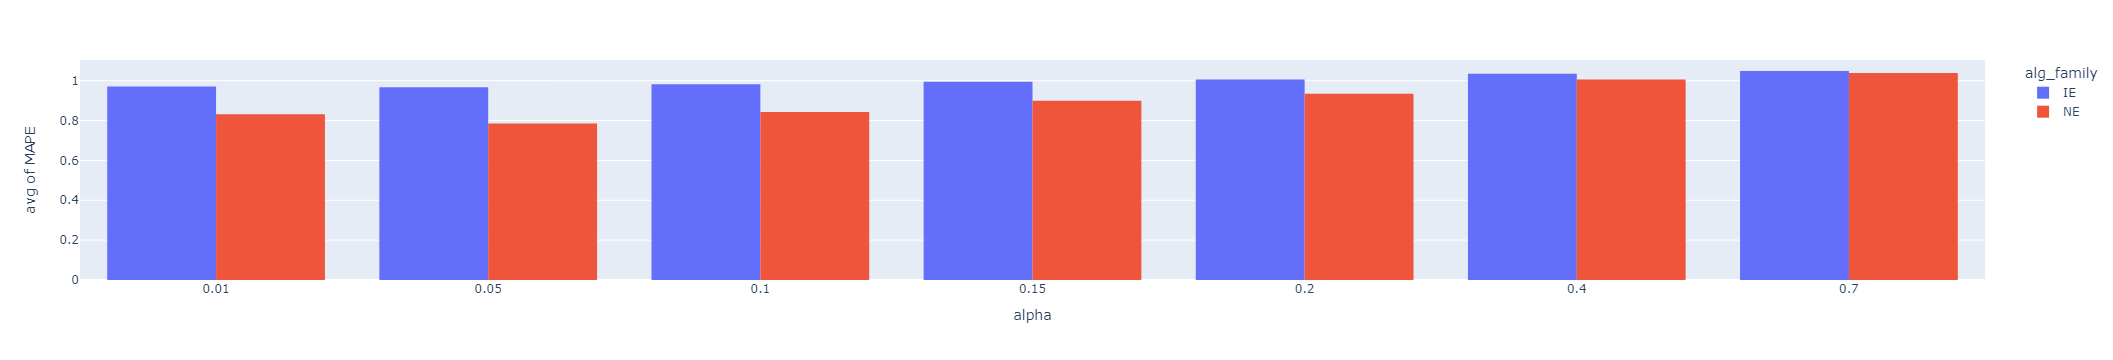

In [44]:
# compare ES methods in first 100 steps
qlt_100 = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in qlt_100.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        qlt_100[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])


qlt_plot = qlt_100.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'})
qlt_plot['alg_family'] = [x[:2] for x in qlt_plot['algs']]
qlt_plot['alpha'] = [x[x.find('alpha')+8:x.find(',')] for x in qlt_plot['algs']]
px.histogram(qlt_plot, x="alpha", y="MAPE",
             color='alg_family', barmode='group', histfunc='avg')

## Adaptive ES (self-study)
Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, глава 1

Tracking signal see 1.

$e_t = y_t - \hat{y}_t$

$\tilde{e}_t = \gamma e_{t-1} + (1-\gamma) \tilde{e}_{t-1}$

$\overline{e}_t = \gamma \left|e_{t-1}\right| + (1-\gamma) \overline{e}_{t-1}$

* Tracking signal

$$K_t = \frac{\tilde{e}_t}{\overline{e}_t}$$

* to do algorithm more stable
$$\alpha_t = \left|K_{t-1}\right|$$

In [45]:
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series,
# h <scalar> - forecasting delay
# Params <dict> - dictionary with
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2

            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

In [46]:
#fit parameters
GAMMA = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
alpha = 0.1
AESparams = [{'alpha':alpha, 'gamma':gamma, 'AdaptationPeriod': 5} for gamma in GAMMA]
FRC_TS = build_forecast(h=1, ts=ts, alg_name =  'SimpleExponentialSmoothing', alg_title='ES' ,params = ESparams)
FRC_TS.update(build_forecast(h=1, ts=ts, alg_name =  'InitExponentialSmoothing', alg_title='IES' ,params = ESparams))
FRC_TS.update(build_forecast(h=1, ts=ts, alg_name =  'NormExponentialSmoothing', alg_title='NES' ,params = ESparams))
FRC_TS.update(build_forecast(h=1, ts=ts, alg_name =  'AdaptiveExponentialSmoothing', alg_title='AES' ,params = AESparams))

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getit

In [47]:
# compare ES methods
qlt_ = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(qlt_.columns):
    frc_ts = FRC_TS[model]
    qlt_[model],_ = qualityMAPE(ts, frc_ts)



qlt_plot = qlt_.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'})
qlt_plot['alg_family'] = [x[:2] for x in qlt_plot['algs']]
qlt_plot['alpha'] = [x[x.find('alpha')+8:x.find(',')] for x in qlt_plot['algs']]
px.histogram(qlt_plot, x="items", y="MAPE",
             color='alg_family', barmode='group', histfunc='min')

** Conclusion**: Adaptive ES rarely outperforms SES and it's modifications

In [48]:
# Sort Quality
qlt_[qlt_.columns].mean().sort_values()

NES {'alpha': 0.01, 'AdaptationPeriod': 5}                    0.790717
ES {'alpha': 0.01, 'AdaptationPeriod': 5}                     0.791620
AES {'alpha': 0.1, 'gamma': 0.005, 'AdaptationPeriod': 5}     0.796167
NES {'alpha': 0.05, 'AdaptationPeriod': 5}                    0.800726
ES {'alpha': 0.05, 'AdaptationPeriod': 5}                     0.800987
AES {'alpha': 0.1, 'gamma': 0.001, 'AdaptationPeriod': 5}     0.802603
AES {'alpha': 0.1, 'gamma': 0.0005, 'AdaptationPeriod': 5}    0.804516
NES {'alpha': 0.1, 'AdaptationPeriod': 5}                     0.804587
ES {'alpha': 0.1, 'AdaptationPeriod': 5}                      0.804595
AES {'alpha': 0.1, 'gamma': 0.01, 'AdaptationPeriod': 5}      0.805314
IES {'alpha': 0.05, 'AdaptationPeriod': 5}                    0.806022
AES {'alpha': 0.1, 'gamma': 0.0001, 'AdaptationPeriod': 5}    0.806740
AES {'alpha': 0.1, 'gamma': 5e-05, 'AdaptationPeriod': 5}     0.807060
IES {'alpha': 0.1, 'AdaptationPeriod': 5}                     0.807400
ES {'a

## Case when SES doesn't work

In [49]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot().update_layout(height=350, width=1300).show()

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Questions**
    - Which charachteristic of TS can you mention so far?

Wage ts forecast with SES alpha =0.1

In [50]:
ESparams = [{'alpha':0.1, 'AdaptationPeriod':10}]
FRC_WAGE = build_forecast(h=1, ts=wage, alg_name =  'SimpleExponentialSmoothing', alg_title='SES' ,params = ESparams)

plot_ts_forecast(wage.loc['1993-01-01':'2017-01-01'], FRC_WAGE[list(FRC_WAGE)[0]].loc['1993-01-01':'2017-01-01']
               , ts_num=0, alg_title='IES alpha=0.1')

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: Future

**Question**
  * What indicates that forecast is inadequate (=there could be more proper forecast)?

Search for the optimal $\alpha$

In [51]:
ALPHA = np.linspace(0.01,0.99,99)
ESparams = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = build_forecast(h=1, ts=wage, alg_name =  'SimpleExponentialSmoothing', alg_title='SES' ,params = ESparams)

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getit

In [52]:
# compare ES parameters
qlt_wage = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09-01':'2018-01-01'].index
for param_cntr in sorted(qlt_wage.columns):
    frc_wage = FRC_WAGE[param_cntr]
    qlt_wage[param_cntr],_ = qualityMAPE(wage.loc[ix], frc_wage.loc[ix])

qlt_wage[qlt_wage.columns].mean().sort_values()

SES {'alpha': 0.38, 'AdaptationPeriod': 10}                   0.058839
SES {'alpha': 0.37, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.39, 'AdaptationPeriod': 10}                   0.058851
SES {'alpha': 0.4, 'AdaptationPeriod': 10}                    0.058872
SES {'alpha': 0.36000000000000004, 'AdaptationPeriod': 10}    0.058888
                                                                ...   
SES {'alpha': 0.05, 'AdaptationPeriod': 10}                   0.129426
SES {'alpha': 0.04, 'AdaptationPeriod': 10}                   0.147997
SES {'alpha': 0.03, 'AdaptationPeriod': 10}                   0.175454
SES {'alpha': 0.02, 'AdaptationPeriod': 10}                   0.219394
SES {'alpha': 0.01, 'AdaptationPeriod': 10}                   0.298435
Length: 99, dtype: float64

draw the forecast with optimial value $\alpha $

In [53]:
# draw the forecast with optimial value 𝛼
best_alg_name = qlt_wage[qlt_wage.columns].mean().sort_values().index[0]
plot_ts_forecast(wage.loc['1999-01-01':'2017-01-01'], FRC_WAGE[best_alg_name].loc['1999-01-01':'2017-01-01']
               , ts_num=0, alg_title=best_alg_name)

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Question**
  - Why is the forecast still inadequate?
  - Is it possible to detect forecast illness looking at forecast accuracy?
  - What is the best rule to detect that SES is not proper?

Calculate loss of the forecast of TS in [02.2016, 01.2017]

In [54]:
qualityMAPE(wage.loc['2016-02-01':'2017-01-01'], FRC_WAGE[best_alg_name].loc['2016-02-01':'2017-01-01'])[0]

Real wage    0.056378
dtype: float64

SES to Yearly Wage Data

In [55]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year[-4:]

Real wage
Month                
2013-01-01     2940.9
2014-01-01     3007.2
2015-01-01     2766.7
2016-01-01     2790.6

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



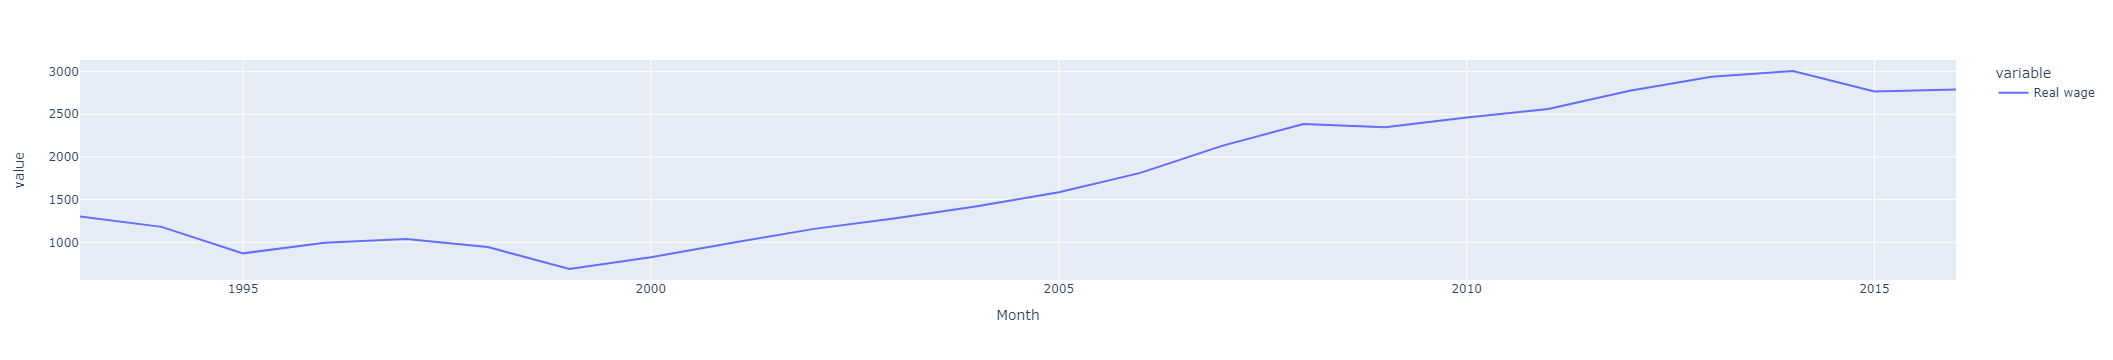

In [56]:
wage_year.plot().update_layout(height=350, width=1300).show()

Search of optimal $\alpha$ for aggregated data

In [57]:
ALPHA = np.linspace(0.01,1,100)
ESparams = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, alg_name =  'SimpleExponentialSmoothing', alg_title='IES'
                              ,params = ESparams, step='12MS')

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:27: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\lakeo\AppData\Local\Temp\ipykernel_6680\3165536848.py:22: FutureWarning:

Series.__getit

In [58]:
# compare ES parameters
qlt_wage_y = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['1999-01':'2010-01'].index
for param_cntr in sorted(qlt_wage_y.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    qlt_wage_y[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

qlt_wage_y[qlt_wage_y.columns].mean().sort_values()[:5]

IES {'alpha': 1.0, 'AdaptationPeriod': 10}                   0.132986
IES {'alpha': 0.99, 'AdaptationPeriod': 10}                  0.133505
IES {'alpha': 0.98, 'AdaptationPeriod': 10}                  0.134027
IES {'alpha': 0.97, 'AdaptationPeriod': 10}                  0.134553
IES {'alpha': 0.9600000000000001, 'AdaptationPeriod': 10}    0.135084
dtype: float64

Forecast with optimial value  $\alpha$

C:\Users\lakeo\.conda\envs\atsf_env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



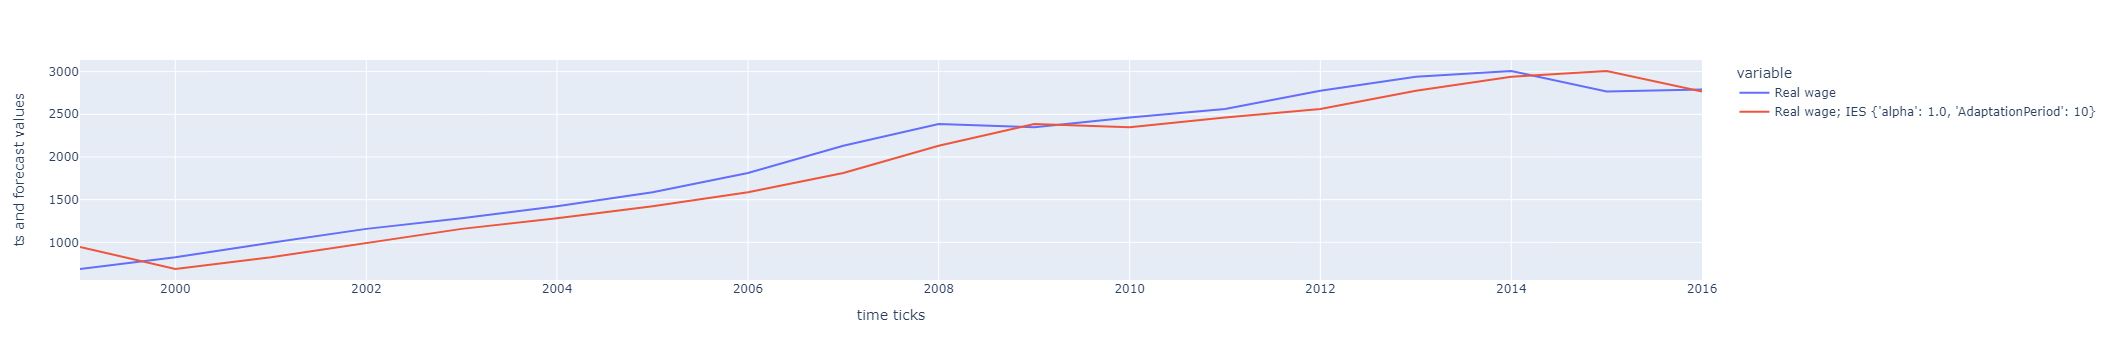

MAPE: Real wage    0.047746
dtype: float64


In [59]:
best_alg_name = qlt_wage_y[qlt_wage_y.columns].mean().sort_values().index[0]
plot_ts_forecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[best_alg_name].loc['1999-01-01':'2016-01-01']
               , ts_num=0 , alg_title=best_alg_name)

print('MAPE: %s' % qualityMAPE(wage_year.loc['2015-01-01':'2016-01-01'], FRC_WAGE_YEAR[best_alg_name].loc['2015-01-01':'2016-01-01'])[0])

**Question**
  - Why is the forecast still inadequate?
  - Is it possible to detect forecast illness looking at forecast accuracy?
  - What is the best rule to detect that SES is not proper?



**<font color='green'> Remember</font>**
  
   Empirical rules:

   - if $\alpha^*\in(0,0.3)$ the series is stationary, SES works;

   - if $\alpha^*\in(0.3,1)$ the series is non-stationary, we need a more sophisticated (trend or seasonal) model.

# Prophet vs Simple Exponential Smoothing

In [ ]:
!pip install prophet

In [16]:
# generate forecast with SES for h = 100 next days after fs_start_dt
fs_start_dt = '2007-07-01'
ix = pd.date_range(pd.to_datetime(fs_start_dt), pd.to_datetime(fs_start_dt)+timedelta(h) )
h = 100

ALPHA = [0.2, .15, 0.1, 0.05, 0.01, 0.005, 0.001]
ESparams = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=h, ts=ts[:fs_start_dt], alg_name =  'SimpleExponentialSmoothing', alg_title='ES' ,params = ESparams)

# frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)
# quality_prophet = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

quality_100days = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within first 100 steps after fs_start_dt
for model in quality_100days.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        quality_100days[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

In [27]:
from prophet import Prophet

#suppressing the info logs
import logging
# logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

fig = make_subplots(rows=5, cols=2, subplot_titles=ts.columns)
i = 0
for col in ts.columns[:10]:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts[col])
    df['ds'] = df.index
    df.columns = ['y', 'ds']

    #making predictions
    m = Prophet()
    m.fit(df)

    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)

    # plotting the results
    fig.add_trace(
        go.Scatter(x=df['ds'], y=df['y'], name=col),
        row=i % 5+1, col= i//5+1
    )
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prophet forecast'),
        row=i % 5+1, col= i//5+1
    )
    # print(i%5+1, i//5+1)
    i+=1
fig.update_layout(height=1000, width=1350, title_text="prophet forecast")
fig.show()
# forecast.set_index('ds').merge(df.set_index('ds'), how = 'outer', left_index = True, right_index = True)[['y','yhat']].plot().update_layout(height=350, width=1300).show()
# quality_wholehist1.loc[col, 'FBP'],_ = qualityMAPE(df.set_index('ds')['y'], forecast.set_index('ds')['yhat'])


In [35]:
forecast[forecast['ds']>fs_start_dt]

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
586 2007-07-02  3.163923   -1.377024    7.059645     3.163923     3.163923   
587 2007-07-03  3.162059   -1.963124    6.661671     3.162059     3.162059   
588 2007-07-04  3.160196   -1.166668    7.132801     3.160196     3.160196   
589 2007-07-05  3.158332   -1.278981    7.325158     3.158332     3.158332   
590 2007-07-06  3.156468   -0.360997    8.015367     3.156468     3.156469   
..         ...       ...         ...         ...          ...          ...   
680 2007-10-04  2.988716   -1.311398    7.569745     2.954525     3.025295   
681 2007-10-05  2.986852   -0.568683    8.122416     2.952233     3.024144   
682 2007-10-06  2.984988    0.078417    8.678101     2.949847     3.022908   
683 2007-10-07  2.983124   -1.035981    7.708105     2.947379     3.021695   
684 2007-10-08  2.981260   -2.300526    6.459346     2.945246     3.020627   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
586       -0.516882             -0.516882             -0.516882 -0.848340   
587       -0.658957             -0.658957             -0.658957 -0.963814   
588       -0.126186             -0.126186             -0.126186 -0.392327   
589       -0.112537             -0.112537             -0.112537 -0.327965   
590        0.619483              0.619483              0.619483  0.466429   
..              ...                   ...                   ...       ...   
680        0.131832              0.131832              0.131832 -0.327965   
681        0.749664              0.749664              0.749664  0.466429   
682        1.650821              1.650821              1.650821  1.528749   
683        0.516245              0.516245              0.516245  0.537268   
684       -0.992147             -0.992147             -0.992147 -0.848340   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
586     -0.848340     -0.848340  0.331458      0.331458      0.331458   
587     -0.963814     -0.963814  0.304856      0.304856      0.304856   
588     -0.392327     -0.392327  0.266141      0.266141      0.266141   
589     -0.327965     -0.327965  0.215427      0.215427      0.215427   
590      0.466429      0.466429  0.153054      0.153054      0.153054   
..            ...           ...       ...           ...           ...   
680     -0.327965     -0.327965  0.459797      0.459797      0.459797   
681      0.466429      0.466429  0.283235      0.283235      0.283235   
682      1.528749      1.528749  0.122072      0.122072      0.122072   
683      0.537268      0.537268 -0.021023     -0.021023     -0.021023   
684     -0.848340     -0.848340 -0.143807     -0.143807     -0.143807   

     multiplicative_terms  multiplicative_terms_lower  \
586                   0.0                         0.0   
587                   0.0                         0.0   
588                   0.0                         0.0   
589                   0.0                         0.0   
590                   0.0                         0.0   
..                    ...                         ...   
680                   0.0                         0.0   
681                   0.0                         0.0   
682                   0.0                         0.0   
683                   0.0                         0.0   
684                   0.0                         0.0   

     multiplicative_terms_upper      yhat  
586                         0.0  2.647041  
587                         0.0  2.503102  
588                         0.0  3.034010  
589                         0.0  3.045794  
590                         0.0  3.775951  
..                          ...       ...  
680                         0.0  3.120548  
681                         0.0  3.736516  
682                         0.0  4.635809  
683                         0.0  3.499369  
684                         0.0  1.989113  

[99 rows x 19 columns]

In [38]:
# generate forecast since fs_start_dt

fig = make_subplots(rows=5, cols=2, subplot_titles=ts.columns)
i = 0
for col in ts.columns[:10]:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts.loc[:fs_start_dt, col])
    df['ds'] = ts[:fs_start_dt].index
    df.columns = ['y', 'ds']

    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)

    # plotting the results
    fig.add_trace(
        go.Scatter(x=ts.loc[ix,:].index, y=ts.loc[ix, col], name=col),
        row=i % 5+1, col= i//5+1
    )
    fig.add_trace(
        go.Scatter(x=forecast[forecast['ds']>fs_start_dt]['ds'], y=forecast[forecast['ds']>fs_start_dt]['yhat'], name='prophet forecast'),
        row=i % 5+1, col= i//5+1
    )
    # print(i%5+1, i//5+1)
    i+=1
    quality_100days.loc[col, 'FBP'],_ = qualityMAPE(ts.loc[fs_start_dt:, col], forecast.set_index('ds').loc[fs_start_dt:, 'yhat'])

fig.update_layout(height=1000, width=1350, title_text="prophet forecast")
fig.show()


In [39]:
# compare accuracy of SES and prophet
px.histogram(quality_100days.unstack().reset_index().rename(columns = {'level_0':'algs', 'level_1':'items', 0:'MAPE'}), x="items", y="MAPE",
             color='algs', barmode='group', histfunc='sum')

# Chech Questions

  * What is an idea of exponential smoothing model? Why expinential smoothing model could work for some time series?
  * What is the difference between moving average and exponential smoothing?
  * Why ES model has exponential law?
  * Descrive behaviour of exponentail smoothing forecast when smoothing paramter $\alpha$ goes to 0 (goes to 1).
  * Write down formula of exponential smoothing forecast.
  * How to initialize forecast value of the first element of time series ?
  * How to fit smoothing paramter $\alpha$?
  * How to define that Simple Exponential Smoothing model does not fit to a time series?

# Materials


* Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.